In [2]:
import sys
sys.path.append('..')
from evaluation.generated_dataset import load_all_from_config, GeneratedDataset
import pandas as pd

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.12/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


In [3]:
train_val_ = load_all_from_config(datasets=[("split", "train"), ("split", "val")])
train_val = pd.concat((d.data for d in train_val_.values()), axis=0, ignore_index=False)

In [4]:
test = GeneratedDataset.from_cache(("split", "test")).data

In [5]:
wt = GeneratedDataset.from_cache(("WyckoffTransformer", )).data.sample(len(test), random_state=42)

In [6]:
from itertools import chain, repeat
from collections import Counter

In [7]:
def collect_tokens(fingerprint):
    counts = Counter()
    for equivalent_set in fingerprint[1]:
        for ese, count in equivalent_set:
            counts[(fingerprint[0], ese[1], ese[2])] += count
    return counts
         

def record_to_token_counter(row):
    """
    Produces a non-augmented token counter from a row
    """
    return Counter(
        map(tuple, zip(repeat(row["spacegroup_number"]), row["site_symmetries"], row["sites_enumeration"])))

In [8]:
test_token_counts = test.apply(record_to_token_counter, axis=1).sum()

In [9]:
test_token_counts.most_common(10)

[((1, '1', 0), 2663),
 ((12, 'm', 0), 1567),
 ((2, '1', 0), 1558),
 ((225, 'm-3m', 0), 1450),
 ((225, 'm-3m', 1), 1368),
 ((225, '-43m', 0), 1366),
 ((62, '.m.', 0), 1092),
 ((8, 'm', 0), 1002),
 ((63, 'm2m', 0), 743),
 ((14, '1', 0), 705)]

In [10]:
augmented_test_token_counts = test.fingerprint.apply(collect_tokens).sum()

In [11]:
augmented_test_token_counts.most_common(10)

[((2, '1', 0), 5809),
 ((12, 'm', 0), 4362),
 ((225, 'm-3m', 1), 2810),
 ((225, 'm-3m', 0), 2810),
 ((225, '-43m', 0), 2724),
 ((1, '1', 0), 2663),
 ((156, '3m.', 2), 1910),
 ((156, '3m.', 0), 1910),
 ((156, '3m.', 1), 1910),
 ((14, '1', 0), 1908)]

In [12]:
train_val_token_counts = train_val.fingerprint.apply(collect_tokens).sum()

In [13]:
wt_token_counts = wt.apply(record_to_token_counter, axis=1).sum()

In [14]:
len(test)

9046

In [15]:
len(test_token_counts.keys() - train_val_token_counts.keys())

21

1. There are no precise details on how many tokens were formed from the MP-20 dataset after tokenization. It would be interesting to discuss this number and other statistics about the tokens, e.g., which tokens are present more often (for some of the high symmetry space groups) and how the distribution of tokens affects training.

In [16]:
mp_20_token_counts = augmented_test_token_counts + train_val_token_counts

In [17]:
len(mp_20_token_counts)

1047

In [18]:
mp_20_token_freq_pd = pd.Series(mp_20_token_counts).sort_values(ascending=False)
mp_20_token_freq_pd /= mp_20_token_freq_pd.sum()

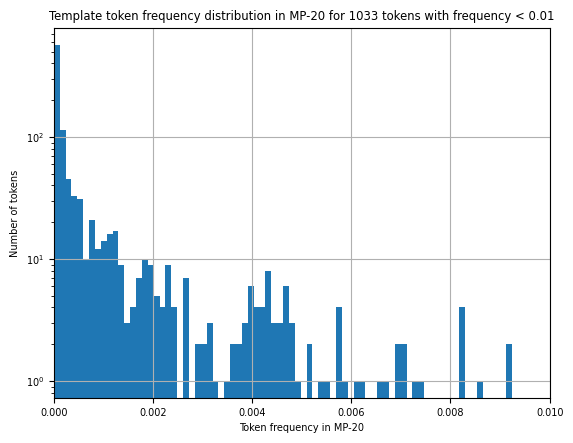

In [19]:
import matplotlib
import matplotlib.pyplot as plt
font = {'size': 7}
matplotlib.rc('font', **font)
fig, ax = plt.subplots()
mp_20_token_freq_pd.hist(bins=500, ax=ax)
threshold = 0.01
ax.set_xlim(0, threshold)
ax.set_xlabel("Token frequency in MP-20")
ax.set_ylabel("Number of tokens")
ax.set_yscale("log");
ax.set_title(f"Template token frequency distribution in MP-20 for {(mp_20_token_freq_pd < 0.01).sum()} tokens with frequency < {threshold}");

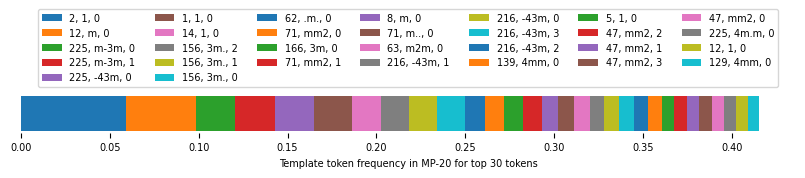

In [20]:
fig, ax = plt.subplots(figsize=(10, 0.5))
start = 0
top_count = 30
cmap = matplotlib.colormaps['tab10']
for i, (token, frequency) in enumerate(mp_20_token_freq_pd.iloc[:top_count].items()):
    ax.barh(0, frequency, left=start, color=cmap(i % cmap.N), label=f"{token[0]}, {token[1]}, {token[2]}")
    start += frequency
ax.set_yticks([])
ax.set_xlabel(f"Template token frequency in MP-20 for top {top_count} tokens")
ax.legend(ncol=7, bbox_to_anchor=(0.5, 2.2), loc='center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

2. It is also important to add how many new tokens the method generates or if it just predicts the fixed set of tokens in different combinations (and these combinations result in more template novelty than just sampling existing templates from training data). For instance, naively thinking about it, how will your model generate tokens that are not present in its dictionary?


In [21]:
print(len(wt_token_counts.keys() - train_val_token_counts.keys()), len(test_token_counts.keys() - train_val_token_counts.keys()))

20 21


3. Another thing is that the token space is relatively smaller, so how can it be argued that these tokens cover all possible values a token could take in real material? Since we do not expect to see new tokens during generation, it should be added as a limitation of the method.

In [22]:
(wt_token_counts - train_val_token_counts).most_common(10)

[((188, '1', 0), 2),
 ((139, 'm..', 0), 1),
 ((224, '.3m', 0), 1),
 ((224, '2.mm', 0), 1),
 ((140, '..2', 0), 1),
 ((72, '2..', 0), 1),
 ((131, '2mm.', 2), 1),
 ((23, '.2.', 0), 1),
 ((23, '2..', 0), 1),
 ((164, '1', 1), 1)]

In [23]:
len(wt)-wt.fingerprint.isin(train_val.fingerprint).sum()

8161

In [24]:
import gzip
import pickle
with gzip.open("../cache/wychoffs_enumerated_by_ss.pkl.gz", "rb") as f:
    a, letter_from_ss_enum, ss_from_letter = pickle.load(f)

In [30]:
all_ss = frozenset(chain(*((s.values() for s in ss_from_letter.values()))))

In [36]:
missing_ss = all_ss - frozenset(mp_20_token_freq_pd.index.get_level_values(1).unique())

In [40]:
len(missing_ss)

7

In [54]:
bad_sg = dict([(sg, missing_ss.intersection(d.keys())) for sg, d in letter_from_ss_enum.items() if missing_ss.intersection(d.keys())])

In [59]:
train_val.spacegroup_number.isin(bad_sg.keys()).sum()

1654

In [46]:
letter_from_ss_enum[34]

defaultdict(dict, {'..2': {0: 'a', 1: 'b'}, '1': {0: 'c'}})

In [39]:
len(all_ss)

82

In [125]:
len(frozenset(chain(*((s.values() for s in ss_from_letter.values())))))

82